In [212]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
import pickle

import torch

from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel, LightGBMModel, \
                        CatBoostModel, XGBModel,  BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel
from darts.dataprocessing.transformers import Scaler

from sklearn.svm import SVC
from sklearn.linear_model import PoissonRegressor


from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [213]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [214]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
cities = ['An Giang','BR Vũng Tàu']

In [215]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [216]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [217]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [218]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [219]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Diarrhoea rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [220]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [221]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [222]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y)

In [223]:
def train_and_evaluate(df_train, df_eval, model, feature_list , labels, scaler, is_dl_algo,nstep):
  """
  $df: pandas.DataFrame object containing data for training and testing model:
  $model: darts model object
  $feature_list: Names of the features used as model input
  $label: the value the model will be trained to predict
  $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
  $lags: how much to look back into the past to output prediction
  $split_index: the point at which to divide train and test_data

  """

  if is_dl_algo == 1:
    print("🍋")
  else:
    x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
    y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

    df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ]

    x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
    y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

    model.fit(y_train, past_covariates = x_train)

    prediction = model.predict(args.test_size, past_covariates = x_test, num_samples=1)

    df_eval = df_eval[args.look_back:]
    y_true = df_eval[labels].values
    df_eval[labels]= np.array(prediction._xa).squeeze()
    y_pred = scaler.inverse_transform(df_eval.iloc[:,:-1])[:,[-1]].reshape(len(prediction))


    df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    df_compare_test_predict.plot()
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mse**0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"mean_squared_error: {mse:.4f}")
    print(f"rmse: {rmse}")
    print(f"mape: {mape}")
    y_true, y_pred, mse, mae, rmse, mape = 0
    return model, y_true, y_pred, mse, mae, rmse, mape

In [224]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler, is_dl_algo, nstep):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate(df_train, df_eval, model, feature_list, labels, scaler,is_dl_algo,nstep)
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-len(prediction_inverse):],
                                  "Observed": y_true[-len(prediction_inverse):],
                                  f"{nstep}-month": prediction_inverse})
    

    df_prediction["City"] = location
    df_prediction[f"RMSE_{nstep}-month"] = rmse
    df_prediction[f"MAE_{nstep}-month"] = mae
    df_prediction[f"MAPE_{nstep}-month"] = mape
    df_prediction[f"MSE_{nstep}-month"] = mse

    temp_rs = f"{rmse},{mae},{mape},{mse}"
    print("rmse,mae,mape,mse")
    print(temp_rs)
    
    return df_prediction, model

In [225]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv", encoding = 'unicode_escape')
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [226]:
def getHyperParams(model_name, city, nstep):
  folder_path = f'../optimize_hyperparam/opt_results/opt_res_ml_26102023/{model_name}/'
  file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_{nstep}-nstep.xlsx'
  df_optimized = pd.read_excel(file_path)
  df_optimized_params = df_optimized.loc[(df_optimized['City'] == city)]
  return df_optimized_params

# Training

In [227]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [228]:
cities

['An Giang', 'BR Vũng Tàu']

✨✨✨✨✨✨✨✨1✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
dkno -39


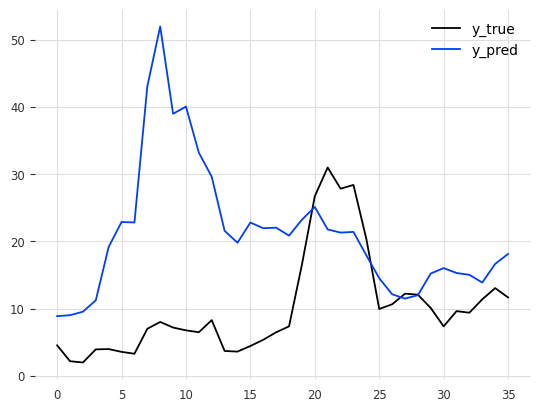

mean_squared_error: 271.5417
rmse: 16.47852293180251
mape: 2.1726663125575927


TypeError: cannot unpack non-iterable int object

In [229]:
model_name_list = [
     "RandomForest",
    #  "LinearRegressionModel",
    #  "LightGBMModel",
    #  "CatBoostModel",
    #  "XGBModel",
    # "PoissonRegressor",
    # "SVMRBF"
]

# for nstep in range(1,args.n_predicted_period_months+1):
for nstep in range(1,2):
    print(f"✨✨✨✨✨✨✨✨{nstep}✨✨✨✨✨✨✨✨✨✨")
    for model_name in model_name_list:   
        print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
        for city in cities:
            print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
            df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            df_valid = pd.read_csv(output_process+city+'_test_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok

            selected_features = getDataWithSelectedFeature(city, nstep)

            lags_by_nstep = args.look_back + nstep - 1
            lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
            is_dl_algo = 0

            pl_trainer_kwargs = {
                        "accelerator": "cpu",
                        # "devices": -1,
                        # "auto_select_gpus": True,
                    }

            df_hyper_params = getHyperParams(model_name, city, nstep)

            if model_name == "RandomForest":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the RandomForest model
                    model = RandomForest(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates_by_nstep,
                                    output_chunk_length = int(output_chunk_length),
                                    n_estimators = int(n_estimators),
                                    max_depth = int(max_depth),
                                    random_state=int(random_state))
            elif model_name == 'XGBModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    # Create the  model
                    model = XGBModel(
                                    lags = lags_by_nstep,
                                    lags_past_covariates = lags_past_covariates_by_nstep,
                                    output_chunk_length = output_chunk_length,
                                    random_state=random_state,
                                    likelihood = likelihood
                                    )
            elif model_name == 'LinearRegressionModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the  model
                    model = LinearRegressionModel(
                                    lags = lags_by_nstep,
                                    lags_past_covariates = lags_past_covariates_by_nstep,
                                    output_chunk_length = output_chunk_length,
                                    random_state=random_state)
            elif model_name == "CatBoostModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    quantiles =  df_hyper_params['quantiles'].values[0]
                    bagging_temperature = df_hyper_params['bagging_temperature'].values[0]
                    border_count = df_hyper_params['border_count'].values[0]
                    l2_leaf_reg = df_hyper_params['l2_leaf_reg'].values[0]
                    random_strength = df_hyper_params['random_strength'].values[0]
                    model = CatBoostModel(
                                            lags=lags_by_nstep,
                                            lags_past_covariates=lags_past_covariates_by_nstep, 
                                            learning_rate=learning_rate,
                                            n_estimators=n_estimators,
                                            max_depth=max_depth, 
                                            output_chunk_length = 1,
                                            likelihood = likelihood,
                                            quantiles = quantiles,
                                            bagging_temperature = bagging_temperature,
                                            border_count = border_count,
                                            l2_leaf_reg = l2_leaf_reg,
                                            random_strength = random_strength,
                                            random_state=random_state)
            elif model_name == "LightGBMModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    multi_models = df_hyper_params['multi_models'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    num_leaves = df_hyper_params['num_leaves'].values[0]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    feature_fraction = df_hyper_params['feature_fraction'].values[0]
                    bagging_fraction = df_hyper_params['bagging_fraction'].values[0]
                    min_child_samples = df_hyper_params['min_child_samples'].values[0]
                    lambda_l1 = df_hyper_params['lambda_l1'].values[0]
                    verbose = df_hyper_params['verbose'].values[0]
                    model = LightGBMModel(
                        lags =lags,
                        lags_past_covariates = lags_past_covariates,
                        output_chunk_length = output_chunk_length,
                        random_state = random_state,
                        multi_models = multi_models,
                        likelihood = likelihood,
                        num_leaves = num_leaves,
                        learning_rate = learning_rate,
                        feature_fraction = feature_fraction,
                        bagging_fraction = bagging_fraction,
                        min_child_samples = min_child_samples,
                        lambda_l1 = lambda_l1,
                        verbose = verbose
                    )          
            df, model = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
                                                            labels=args.labels, scaler=scaler, is_dl_algo = is_dl_algo, nstep = nstep)
            df.to_excel(f"./predict_results/0_train_{nstep}nstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
            pickle.dump(model, open(f"./trained_models/{nstep}nstep_denguefever_{model_name}_in_{city}.sav", 'wb'))